In [ ]:
#!pip install shap
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, copy, time, csv, pickle, PIL

import sklearn
from sklearn import tree as tr
from sklearn import ensemble as ens
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn.tree import _tree

import hyperopt as hpt
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

import shap

## Audio feature gen (preprocessing)

In [ ]:
# Функция преоюразования аудиодорожек в директориях dir1, dir2 в табулированные(csv) данные в директории dir1_out
# Описание выделяемых фичей см в word_descr.docx
# dir1 - <str> - директория первой части датасета для бинарной классификации
# dir2 - <str> - директория второй части датасета для бинарной классификации
# dir1_out - <str> - директория для сохранения собранных таблиц 
def AudioToTable(dir1, dir2, dir1_out):
  dirs = [dir1, dir2]
  cnt = 1
  for dir_ in dirs:
      os.chdir(dir_)
      header = 'filename chroma_stft rmse spectral_centroid spectral_bandwidth rolloff zero_crossing_rate'
      for i in range(1, 21):
          header += f' mfcc{i}'
      header = header.split()
      file = open(os.path.join(dir1_out, r'dataset_%s.csv'%str(cnt)), 'w', newline='')
      with file:
          writer = csv.writer(file)
          writer.writerow(header)
      print('File created: ', os.path.join(dir1_out, r'dataset_%s.csv'%str(cnt)))
      for filename in os.listdir():
          y, sr = librosa.load(filename, mono=True, duration=30)
          rms = librosa.feature.rms(y=y)
          chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
          spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr)
          spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
          rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
          zcr = librosa.feature.zero_crossing_rate(y)
          mfcc = librosa.feature.mfcc(y=y, sr=sr)
          to_append = [filename, str(np.mean(chroma_stft)), str(np.mean(rms)), str(np.mean(spec_cent)),
                      str(np.mean(spec_bw)), str(np.mean(rolloff)), str(np.mean(zcr))]    
          for e in mfcc:
              to_append = to_append + [np.mean(e)]
          file = open(os.path.join(dir1_out, r'dataset_%s.csv'%str(cnt)), 'a', newline='')
          with file:
              writer = csv.writer(file)
              writer.writerow(to_append)
      cnt = cnt + 1

#AudioToTable(dir1, dir2, dir1_out, dir2_out)

## Data load (data has been already transformed into tabular feature form)

In [ ]:
# Загрузка данных из подготовленных таблиц csv
# name - <str> - путь до файла таблицы
def DataLoad(name):
  ff = open(name, 'r')
  rdr = csv.reader(ff)
  data0 = [row for row in rdr]
  global header
  header = data0[0][1:]
  data = np.array(data0[1:])[:, 1:].astype(float)
  ff.close()
  return data

In [ ]:
data_bad = DataLoad(r'dataset_bad2_500.csv')
data_good = DataLoad(r'dataset_good2_500.csv')
X = np.vstack([data_bad, data_good])
Y = np.array(data_bad.shape[0]*[0] + data_good.shape[0]*[1])
x_tr, x_te, y_tr, y_te = ms.train_test_split(X, Y, random_state=42, test_size=0.25)

(array([122.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 128.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

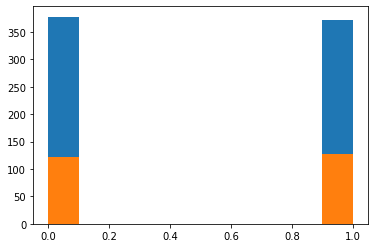

In [ ]:
# Датасет сбалансированный(баланс сохраняется также и в тестовой выборке)
plt.hist(y_tr)
plt.hist(y_te)

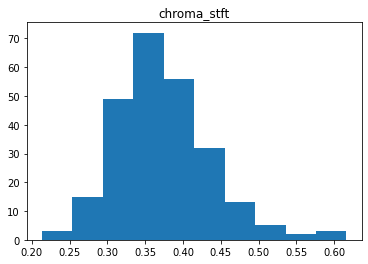

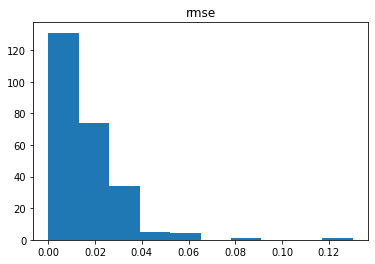

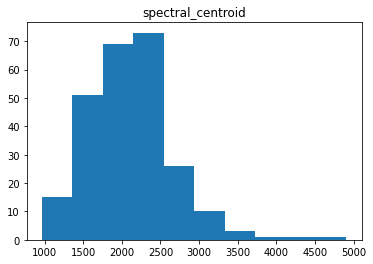

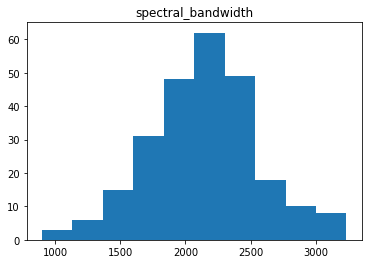

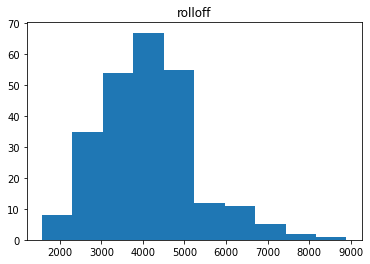

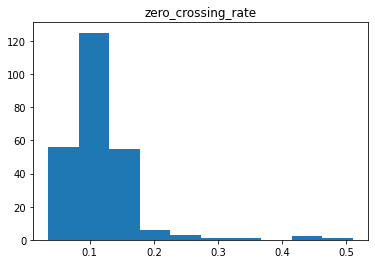

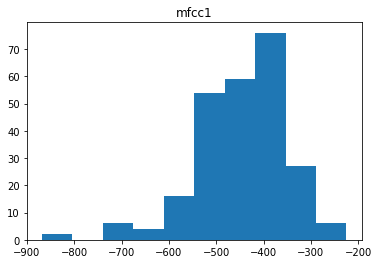

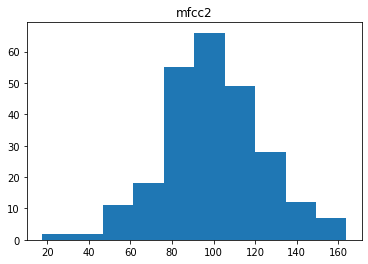

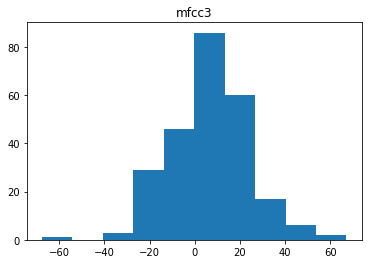

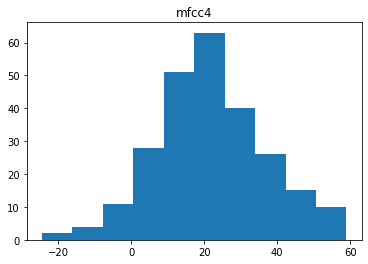

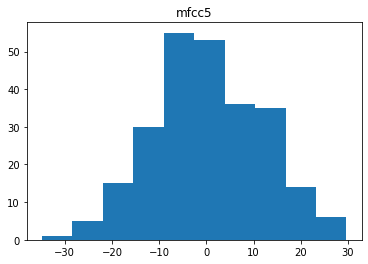

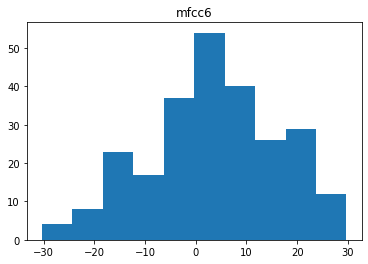

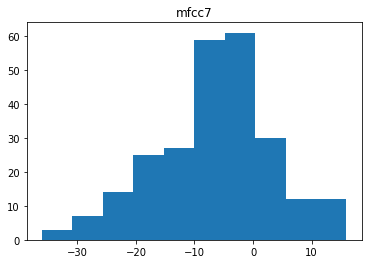

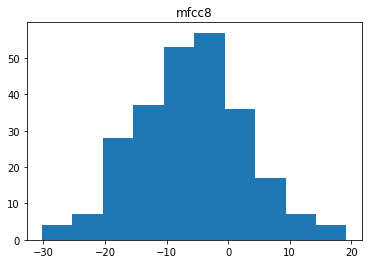

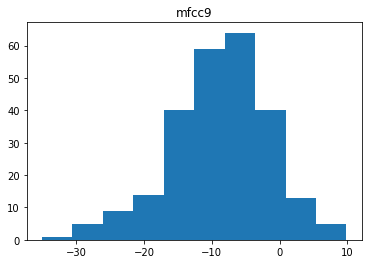

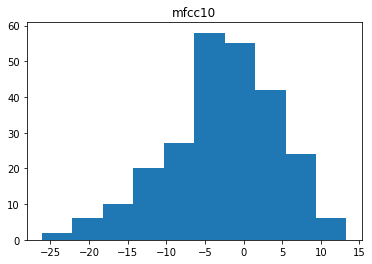

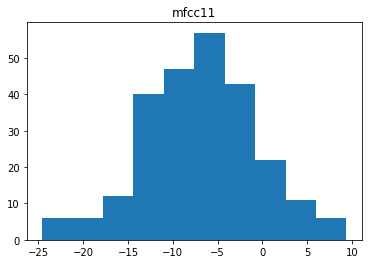

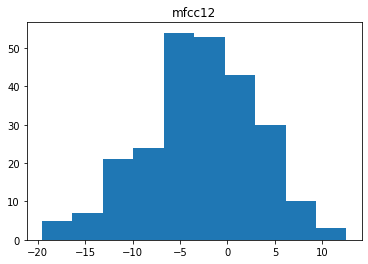

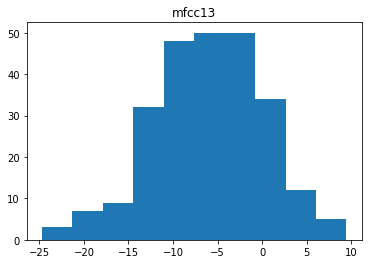

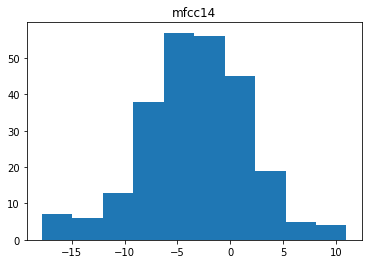

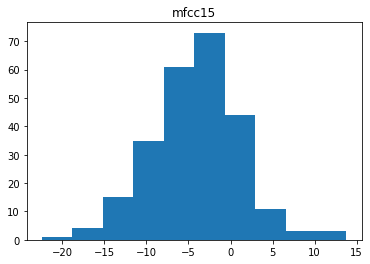

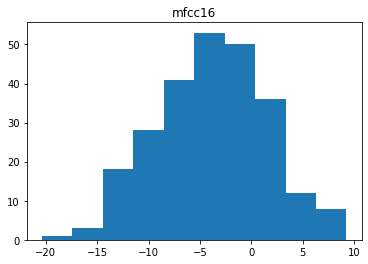

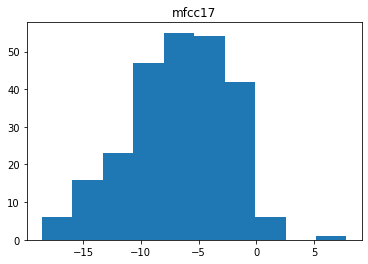

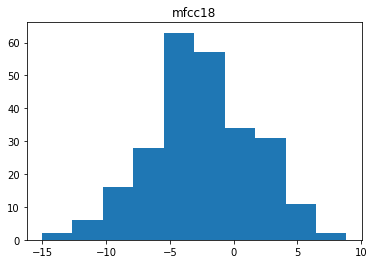

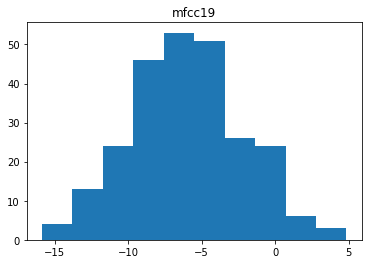

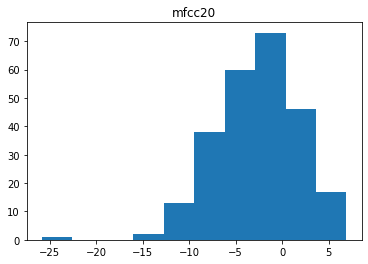

In [ ]:
# Каждый из признаков (кроме rmse, zero_scoring_rate) подвержен описанию по ЦПД
# также ввиду небольшого количества сэмплов некоторые значения могут признаков показаться аномалиями но это не так
# в данном датасете отсутсвуют пропуски данных т.к. он сгенерирован на базе физических характеристик сигнала
for i in range(len(header)):
  plt.title(header[i])
  plt.hist(x_te[:, i])
  plt.show()

## Model training(load) and testing

In [ ]:
# Вспомогательная функция для вычисления компонент результатов бинарной классификации 
# y - <ndarray|list> - список оригинальных значений целевой переменной
# y_pred - <ndarray|list> - список предсказанных моделью значений целевой переменной
def TPFPTNFN(y, y_pred):
    d = {'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0}
    for i in range(len(y)):
        if (y[i]==1) and (y_pred[i]==1): d['TP'] = d['TP'] + 1 
        if (y[i]==1) and (y_pred[i]==0): d['FN'] = d['FN'] + 1 
        if (y[i]==0) and (y_pred[i]==1): d['FP'] = d['FP'] + 1 
        if (y[i]==0) and (y_pred[i]==0): d['TN'] = d['TN'] + 1 
    return d


# Основная метрика качества подобранная эмпирически опираясь на пожелания заказчика
# est - <model_class> -  модель для предсказаний которой нужно посчитать метрику
# X - <ndarray> - набор данных
# Y - <ndarray|list> - оригинальные значения целвой переменной
# hyper - <int|float> - параметр относительной важг=ности компонента FN
# Данная метрика также будет являться loss_func для минимизации в процессе подбора гиперпараметров
def MetricAlgo(est, X, Y, hyper=2):
  prom = TPFPTNFN(Y, est.predict(X))
  prom1 = 1 - mt.roc_auc_score(Y, est.predict(X))
  prom2 = (prom['FN']*hyper + prom['FP'] + 10e-6)
  current_score = prom2*prom1
  return current_score

# Дополнительная loss_func
#def FBloss(est, X, Y, beta=10):
#  current_score = mt.fbeta_score(Y, est.predict(X), beta=beta)
#  return 1 - current_score

In [ ]:
# Список значений соотношений классов - гиперпараметр 
N = 100
LL = [{0: 0.3 + 0.7*i/N, 1: 0.7*(N-i)/N} for i in range(N)]

# Функция подбора гиперпараметров для базового алгоритма - решающего дерева
# params - <dict> - набор гиперпараметров и их вариабельных значений см. ниже
def Tree_score(params):
    TR = tr.DecisionTreeClassifier(**params)
    # Обучение включено в cross_val_score - метрика пользвательская
    current_score = ms.cross_val_score(TR, x_tr, y_tr, scoring=MetricAlgo, cv=10).mean()
    return current_score
 

# Словарь гиперпараметров базового алгоритма
tree_params = {
            'criterion': hp.choice('criterion', ['gini', 'entropy']),
            'max_depth': hp.choice('max_depth', range(5, 30)),
            'min_samples_split':  hp.choice('min_samples_split', range(5, 10)),
            'min_samples_leaf': hp.choice('min_samples_leaf', range(5, 10)),
            'class_weight': hp.choice('class_weight', ['balanced']+LL)
}

# Вызов специальной функции hyperopt - желательно увеличить max_evals
TRbest = fmin(fn=Tree_score, space=tree_params, max_evals=50, algo=hpt.rand.suggest, return_argmin=True)
print('\nBest:')
print(TRbest) 

100%|██████████| 50/50 [00:10<00:00,  4.66it/s, best loss: 12.773189652204836]

Best:
{'class_weight': 25, 'criterion': 0, 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Проверка сбалансированности классов при проведении кросс-валидации на 5 фолдов

#shp = y_tr.shape[0]//5
#for i in range(5):
#  plt.hist(y_tr[shp*i: shp*(i+1)])
#  plt.show()

In [ ]:
# Теперь когда гиперпараметры подобраны используем лучший набор чтобы обучить базовый алгоритм
TR = tr.DecisionTreeClassifier(criterion = ['gini', 'entropy'][TRbest['criterion']],
                               max_depth = list(range(2, 50))[TRbest['max_depth']],
                               min_samples_leaf = list(range(2, 20))[TRbest['min_samples_leaf']],
                               min_samples_split = list(range(2, 10))[TRbest['min_samples_split']],
                               class_weight = (['balanced']+LL)[TRbest['class_weight']],
                              )
# Т.к. настояций датасет сбалансированный то можем использовать базовую метрику кросс валидации
TRscore = ms.cross_val_score(TR, x_tr, y_tr, cv= 5)
print('CV: ', TRscore)
print('CV_mean: ', TRscore.mean())
#Проверим эффективность нашего базового алгоритма на всем датасете
TR.fit(x_tr, y_tr)
print('ROC_AUC tr:', mt.roc_auc_score(y_tr, TR.predict(x_tr)))
print('ROC_AUC te:', mt.roc_auc_score(y_te, TR.predict(x_te)))
print('Metrics tr:', TPFPTNFN(y_tr, TR.predict(x_tr)))
print('Metrics te:', TPFPTNFN(y_te, TR.predict(x_te)))

# оСновным критерием данной работы является уменьшение FN поэтому можно варьировать параметром hyper функции MetricAlgo

CV:  [0.64666667 0.65333333 0.62666667 0.64666667 0.68      ]
CV_mean:  0.6506666666666667
ROC_AUC tr: 0.9387267451783581
ROC_AUC te: 0.6759093237704918
Metrics tr: {'TP': 352, 'FP': 26, 'TN': 352, 'FN': 20}
Metrics te: {'TP': 87, 'FP': 40, 'TN': 82, 'FN': 41}


In [ ]:
# перейдем к наращиванию архитектуры модели

# Функция подбора гиперпараметров для алгоритма 2 уровня - бэггинга-случайного леса
# params - <dict> - набор гиперпараметров и их вариабельных значений см. ниже
def Bag_score(params):
    BA = ens.BaggingClassifier(**params)
    # метрика та же
    current_score = ms.cross_val_score(BA, x_tr, y_tr, scoring=MetricAlgo, cv=10).mean()
    return current_score

bag_params = {
            'base_estimator': hp.choice('base_estimator', [TR, ]),
            'n_estimators': hp.choice('n_estimators', range(10, 30)),
            'max_features':  hp.choice('max_features', np.arange(0.5, 1, 0.1)),
            'max_samples':  hp.choice('max_samples', np.arange(0.5, 1, 0.1))
}
 
BAbest = fmin(fn=Bag_score, space=bag_params, max_evals=50, algo=hpt.rand.suggest, return_argmin=True) #~100
print('\nBest:')
print(BAbest) 

100%|██████████| 50/50 [00:49<00:00,  1.02it/s, best loss: 8.365934339260312]

Best:
{'base_estimator': 0, 'max_features': 4, 'max_samples': 4, 'n_estimators': 15}


In [ ]:
# Теперь когда гиперпараметры подобраны используем лучший набор чтобы обучить алгоритм 2 уровня
BA = ens.BaggingClassifier(base_estimator=TR,
                           n_estimators=range(2, 30)[BAbest['n_estimators']],
                           max_features = np.arange(0.4, 1+0.1, 0.1)[BAbest['max_features']], )
# Т.к. настояций датасет сбалансированный то можем использовать базовую метрику кросс валидации
BAscore = ms.cross_val_score(BA, x_tr, y_tr, cv= 5)
print('CV: ', BAscore)
print('CV_mean: ', BAscore.mean())
#Проверим эффективность нашего базового алгоритма на всем датасете
BA.fit(x_tr, y_tr)
print('ROC_AUC tr:', mt.roc_auc_score(y_tr, BA.predict(x_tr)))
print('ROC_AUC te:', mt.roc_auc_score(y_te, BA.predict(x_te)))
print('Metrics tr:', TPFPTNFN(y_tr, BA.predict(x_tr)))
print('Metrics te:', TPFPTNFN(y_te, BA.predict(x_te)))

CV:  [0.68666667 0.69333333 0.76666667 0.74       0.65333333]
CV_mean:  0.708
ROC_AUC tr: 0.977321215224441
ROC_AUC te: 0.7288037909836066
Metrics tr: {'TP': 363, 'FP': 8, 'TN': 370, 'FN': 9}
Metrics te: {'TP': 89, 'FP': 29, 'TN': 93, 'FN': 39}


## Feature importance

In [ ]:
# Перйдем непосредственно к анализу важности каждой фичи, сделать это можно несколькими методами
# shap - вычислительно очень затратный математически метод вычисления feature_importance (не рабоатет для некоторых типов 
# алгоритмов sklearn)
#https://habr.com/ru/post/428213/
# lime - упрощенный метод построения локальной модели для конкретного сампла, абсолютно всеяден
# https://blog.dominodatalab.com/shap-lime-python-libraries-part-2-using-shap-lime/
# Построение дендрограммы  -  т.к. используемый алгоритм это лес, а не бустинг, то дендрограмма будет наиболее полно
# описывать каждую фичу

In [ ]:
#  Преобразуем наш датасет в dframe pandas с ним удобнее работать в shap
DF = pd.DataFrame(x_tr, columns=header)

In [ ]:
# shap не работатет с бэггиннгом в sklearn но аналогичную операцию можно провести для базового алгоритма
explainerRF = shap.TreeExplainer(BA.base_estimator)
shap_values_RF_train = explainerRF.shap_values(DF)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


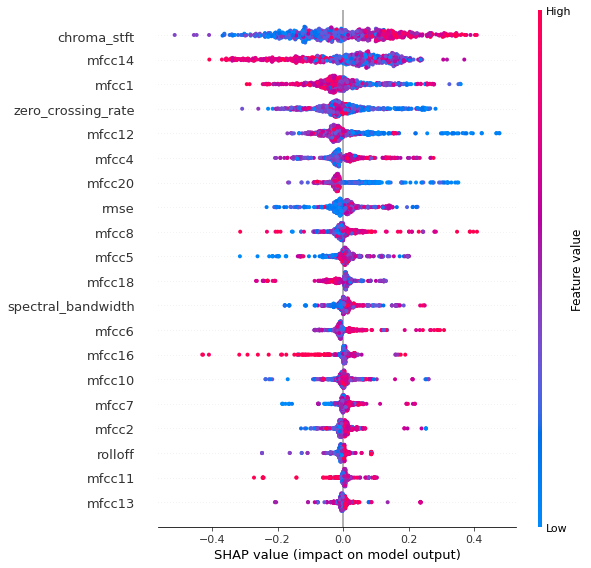

In [ ]:
shap.initjs()
shap.summary_plot(shap_values_RF_train[0], DF)

In [ ]:
# Как видно по графику ни одна из фичей не является "прилипшей" к 0-линии
# из этого следует что каждая фича привносит вклад в определение целевой переменной
# возможно провести более детальный разбор каждой фичи, например

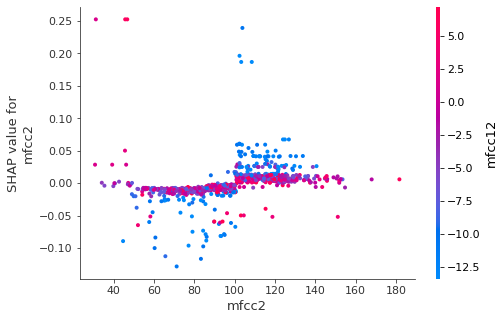

In [ ]:
shp_plt = shap.dependence_plot("mfcc2", shap_values_RF_train[0], DF)

In [ ]:
# также можно исследовать каждый сампл по отдельности
J = 105
shap.initjs()
shap.force_plot(explainerRF.expected_value[0], shap_values_RF_train[0][J], DF.iloc[[J]])

In [ ]:
# также воспользуемся 3 методом и построим дендрограмму интерпретируемую как функцию для нашего базового алгоритма

# Функция "распаковки" дерева
# tree - <sklearn_tree> - модель обученная (дерево или лес)
# feature_names - <list> - наименования фичей
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree({}):".format(", ".join(feature_names)), '\n', '**'*40, '\n')

    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))

    recurse(0, 1)

In [ ]:
tree_to_code(TR, header)

def tree(chroma_stft, rmse, spectral_centroid, spectral_bandwidth, rolloff, zero_crossing_rate, mfcc1, mfcc2, mfcc3, mfcc4, mfcc5, mfcc6, mfcc7, mfcc8, mfcc9, mfcc10, mfcc11, mfcc12, mfcc13, mfcc14, mfcc15, mfcc16, mfcc17, mfcc18, mfcc19, mfcc20): 
 ******************************************************************************** 

  if mfcc14 <= -0.3555705100297928:
    if chroma_stft <= 0.36629801988601685:
      if zero_crossing_rate <= 0.09783633425831795:
        if chroma_stft <= 0.35771749913692474:
          if rmse <= 0.01683717593550682:
            if mfcc6 <= 11.20025634765625:
              if mfcc13 <= -3.6254605054855347:
                if mfcc10 <= -0.5028128623962402:
                  if spectral_bandwidth <= 2168.3985595703125:
                    return [[0.    7.448]]
                  else:  # if spectral_bandwidth > 2168.3985595703125
                    return [[0.468 1.064]]
                else:  # if mfcc10 > -0.5028128623962402
                  if mfcc13 <=